# 201601615 이의찬

# 1. 지정 주제

## 영화: 외계+인 1부

먼저 기술적인 이유는 '외계+인 1부'가 사람들의 호불호가 갈리고 의견의 대립이 첨예하기 때문이다. <br>
원래 선정한 인생영화는 인터스텔라와 위플래쉬였으나 인터스텔라는 평이 너무 좋고 평점이 낮은 리뷰에는 댓글이 잘 달리지 않아서 극적인 결과를 확인하기 힘들었고 위플래쉬는 일반적인 '재미없다'라는 평보다 광기, 싸이코패스 등 일반적이지 않은 평이 많아서 분류기 학습시킨 결과가 아쉬웠기 때문에 좋은 평가와 안 좋은 평가가 골고루 있는 영화 '외계+인 1부'를 선정하게 되었다. 

개인적인 이유는 최근에 'her'라는 영화를 보고 머리를 비우고 싶어서 본 영화이다. 영화를 보기 전에 기대를 하지 않고 봤었고 한국 영화에 드문 참신한 컨셉이 재밌었고 딱 떨이지는 스토리도 좋았다. 인생영화라고 하기엔 2부까지 나와봐야 알겠지만 최근에 재밌게 봐서 선정해 보았다.

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By # find_element 를 할 때, 속성값 관리
from selenium.webdriver.common.keys import Keys
from urllib.request import urlopen
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
from nltk.tokenize import word_tokenize
from urllib.request import urlopen
import nltk
import matplotlib.pyplot as plt
import urllib
import time

okt = Okt()

POS = 9
NEG = 4

In [51]:
driver_path = "chromedriver.exe" # 경로명: 현재 폴더로 되어있음
movie_url = r"https://movie.daum.net/moviedb/grade?movieId=139606"

### selenium 드라이버

In [52]:
driver = webdriver.Chrome(driver_path)
driver.implicitly_wait(3) # 열리는 시간 3초 대기
driver.get(movie_url)

C:\Users\outda\AppData\Local\Temp\ipykernel_10280\3252897723.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


## 1. 영화 리뷰 가져오기

In [53]:
'''리뷰 전부 로드'''
# 평점을 남긴 유저 수(페이지 버튼 누를 횟수 계산할 때 사용)
user_count = driver.find_element(
    By.CLASS_NAME, "txt_netizen"
).text.strip("()명") 

# more 버튼 누르는 총 횟수
more_count = (int(user_count) - 10) // 30 + 1 

# 더보기 버튼
more_button = '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button' 

# 더보기 버튼 클릭
for i in tqdm(range(more_count)):
    driver.find_element(By.XPATH, more_button).click()
    time.sleep(2)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# html 텍스트 파일 저장 코드
html = driver.page_source
text_file = open('inter_review_data.txt', 'w', encoding='utf-8')
text_file.write(html)
text_file.close()

In [22]:
# selenium으로 작업한 url 정보를 html로 가져옴
# html = driver.page_source

with open('inter_review_data.txt', 'r', encoding='utf-8') as f:
    html = f.read()
    f.close()

soup = BeautifulSoup(html, "html.parser")

div_reviews = soup.find_all("div", {"class": "cmt_info"})

# 유저 댓글 평점
# list<<tuple(댓글:str, 평점:int)>>
reviews = []

for review in tqdm(div_reviews):
    comment = review.find("p", {"class": "desc_txt font_size_"}) # 댓글
    
    if not comment:
        # 댓글을 적지 않고 평점만 줬다면 무시
        continue
        
    comment = comment.text.strip() # 댓글
    rating = int(review.find("div").text) # 평점: 첫번째 div
    
    reviews.append((comment, rating))

  0%|          | 0/160 [00:00<?, ?it/s]

#### driver.page_source 사용 이유

```python
html = urlopen(movie_url)
soup = BeautifulSoup(html.read(), "html.parser")
```

`driver.page_source`를 사용하여 현재 `selenium`으로 렌더링 된 페이지의 모든 `Elements`를 모두 가져오고 selenium으로 작업한 url 정보를 html로 가져온다.

## 2. 워드 클라우드 그리기

#### 함수

In [23]:
# from konlpy.tag import Okt
# from collections import Counter
# from wordcloud import WordCloud

# okt = Okt()

def okt_pos_by_filter(text:str, filter=['Noun', 'Verb', 'Adjective']):
    '''
    okt를 이용해서 문장을 단어로
    분리하고 필터링(기본값: 명사, 동사, 형용사)하는 함수
    '''
    result = []
    for t in okt.pos(text, norm=True, stem=True):
        if t[1] in filter:
            result.append(t[0])
            
    return result

def remove_meaningless_words(words):
    '''의미없는 단어 삭제하는 함수'''
    # 한 글자로 이루어진 단어 제거
    stopword_list = []
    
    for word in words:
        if len(word) == 1:
            stopword_list.append(word)

    for stopword in stopword_list:
        words.pop(stopword)

    # 의미없는 동사 제거
    verbs = [
        '하다', '보다', '있다', '되다', '이다', 
        '이렇다', '그렇다', '이겠다'
    ]
    
    for v in verbs:
        if v in words:
            words.pop(v)
    
    return words

def generate_wc_frequencies(word_count):
    '''워드 클라우드 빈도수 객체 생성'''
    wc = WordCloud(
        background_color='white', 
        max_words=5000, 
        font_path=r'C:\Windows\Fonts\gulim.ttc', 
        colormap='seismic'
    )
    return wc.generate_from_frequencies(word_count)

### 2-1. 전체, 긍정, 부정 평가 단어 처리하기

전체: `all_comment_words`, `all_comments_word_count`

긍정: `pos_comment_words`, `pos_comment_word_count`

부정: `neg_comment_words`, `neg_comment_word_count`

In [24]:
# 댓글의 명사, 동사, 형용사만 추출
all_comment_words = []
pos_comment_words = []
neg_comment_words = []

for review in tqdm(reviews):
    comment = review[0].replace("\n", " ")
    rating = review[1]
    
    all_comment_words += okt_pos_by_filter(comment)
    if rating >= POS: 
        pos_comment_words += okt_pos_by_filter(comment)
        
    elif rating <= NEG: 
        neg_comment_words += okt_pos_by_filter(comment)
        
all_comment_word = Counter(all_comment_words)
all_comment_word = remove_meaningless_words(all_comment_word)

pos_comment_word = Counter(pos_comment_words)
pos_comment_word = remove_meaningless_words(pos_comment_word)

neg_comment_word = Counter(neg_comment_words)
neg_comment_word = remove_meaningless_words(neg_comment_word)    

  0%|          | 0/160 [00:00<?, ?it/s]

### 2-3. 워드 클라우드

#### 2-3-1. 전체

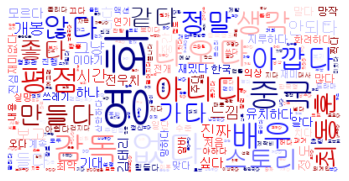

In [25]:
all_wc = generate_wc_frequencies(all_comment_word)
plt.imshow(all_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-2. 전체 결과 해석

전체적으로 재미있다, 좋다라는 평이 많고 타짜, 감독이라는 글자가 큰 이유는 타짜, 도둑들 같은 흥행 작품을 했던 유명한 감독이라서 '감독'이라는 키워드가 자주 언급된 것으로 보인다. 

#### 2-3-3. 긍정 리뷰 워드 클라우드

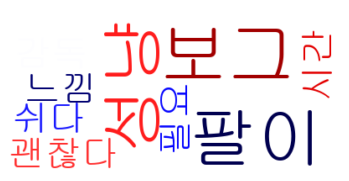

In [26]:
pos_wc = generate_wc_frequencies(pos_comment_word)
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-4. 부정 리뷰 워드 클라우드

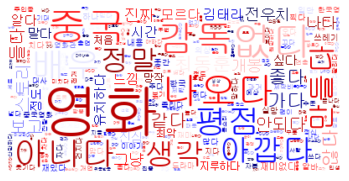

In [27]:
neg_wc = generate_wc_frequencies(neg_comment_word)
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-4. 긍정 리뷰, 부정 리뷰 결과 해석, 비교

## 3. 분류기 학습시키기

#### 함수

In [28]:
def load_data(file_path):
    train = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip()
            id, doc, label = line.split('\t')
            if label == '1': 
                label = 'pos'
            elif label == '0': 
                label = 'neg'
            train.append((doc, label))
    return train

def format_data(reviews):
    train = []
    
    for review in reviews:
        comment = review[0].replace("\n", " ")
        if len(comment) > 140:
            continue
            
        rating = review[1]
        
        if rating >= POS:
            label = 'pos'
        elif rating <= NEG:
            label = 'neg'
        else:
            continue
        
        train.append((comment, label))
        
    return train

def pos_tokenize(raw_sent):
    pos_sent = []
    sent = okt.pos(raw_sent, norm=True, stem=True)
    for tup in sent:
        word, tag = tup[0], tup[1]
        word_tag = word + '/' + tag
        pos_sent.append(word_tag)
    return ' '.join(pos_sent)

def make_word_dict(train, use_morph=False):
    all_words = set()
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        for word in words:
            all_words.add(word)
    return all_words

def make_train_feats(train, all_words, use_morph=False):
    train_features = []
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        tmp = {set_word: (set_word in words) for set_word in all_words}
        sent_tup = (tmp, label)
        train_features.append(sent_tup)
    return train_features

In [29]:
train = format_data(reviews)

In [30]:
use_morph = True
all_words = make_word_dict(train, use_morph)
train_feature = make_train_feats(train, all_words, use_morph)

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

In [31]:
classifier = nltk.NaiveBayesClassifier.train(train_feature)
classifier.show_most_informative_features()

Most Informative Features
                 성냥/Noun = True              pos : neg    =     65.0 : 1.0
                  최/Noun = True              pos : neg    =     39.0 : 1.0
                 팔이/Noun = True              pos : neg    =     39.0 : 1.0
                 느낌/Noun = True              pos : neg    =     17.7 : 1.0
                 시간/Noun = True              pos : neg    =     13.0 : 1.0
                  이/Noun = True              pos : neg    =     10.3 : 1.0
                  도/Josa = True              pos : neg    =      6.7 : 1.0
                 감독/Noun = True              pos : neg    =      5.6 : 1.0
                 하다/Verb = True              pos : neg    =      3.2 : 1.0
           ./Punctuation = True              pos : neg    =      3.0 : 1.0


In [32]:
sents = load_data('ratings_test.txt')

count = 2000
matches_count = 0

for i in tqdm(range(1, count)):
    test_sent = sents[i][0]
    comment = test_sent
    test_sent = pos_tokenize(test_sent)
    words = word_tokenize(test_sent)
    test_feature = {set_word: (set_word in words) for set_word in all_words}
    
    if sents[i][1] == classifier.classify(test_feature):
        matches_count += 1
        
print('일치하는 비율: ', (matches_count/count)*100)

  0%|          | 0/1999 [00:00<?, ?it/s]

일치하는 비율:  48.65


In [33]:
test_sent = "졸다가 나왔음"
test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}
print(classifier.classify(test_feature))

neg


In [34]:
nltk.classify.accuracy(classifier, train_feature)

0.9923076923076923

## 4. 지정 주제 느낀 점 및 자기 평가

# 자유주제

1. 내가 본 영화를 재밌게 본 사람의 다른 재밌는 영화
2. 다른 사이트와 비교
3. 중간 평점 추가
4. 댓글 알바 거르기?
5. 평점 남긴 사람의 이 영화 평점 백분위

In [10]:
# 평점 높은 순 버튼 클릭
my_title = '외계+인 1부'
titles = []
scores = []

for page in tqdm(range(1, 100)):
    url = f'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=192151&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=highest&page={page}'

    html = urlopen(url)
    soup = BeautifulSoup(html.read(), "html.parser")

    div_reviews = soup.find('div', {'class': 'score_result'})
    li_reviews = div_reviews.find_all('li')
    
    for li_review in li_reviews:
        rating = int(li_review.find('div', {'class': 'star_score'}).text.strip())
        div_reple = li_review.find('div', {'class': 'score_reple'})
        dl = div_reple.find('dl')
        user_unique_id = dl.find('a')['onclick'][30:38]
        
        if rating < 8:
            continue
        
        nick_url = 'https://movie.naver.com/movie/point/af/list.naver?st=nickname&target=after&sword=' + user_unique_id
        nick_html = urlopen(nick_url)
        nick_soup = BeautifulSoup(nick_html.read(), "html.parser")
        reviews = nick_soup.find_all('td', {'class': 'title'})
        for review in reviews:
            title = review.find('a', {'class': 'movie color_b'}).text
            
            if title == my_title:
                continue
                
            score = int(review.find(
                'div', {'class': 'list_netizen_score'}
            ).find('em').text)
            
            if score < 8:
                continue
            
            titles.append(title)
            scores.append(score)

  0%|          | 0/99 [00:00<?, ?it/s]

In [50]:
title_count = Counter(titles)
stitles = [(k, v) for k, v in sorted(dict(title_count).items(), reverse=True, key=lambda item: item[1])]

In [51]:
# html 텍스트 파일 저장 코드
text_file = open('free.txt', 'w', encoding='utf-8')
text_file.write(str(stitles))
text_file.close()
# print(titles)

In [57]:
with open('free.txt', 'r', encoding='utf-8') as f:
    import ast
    stitles = f.read()
    stitles = ast.literal_eval(stitles)
    f.close()

[('범죄도시2', 30), ('헌트', 29), ('변호인', 25), ('한산: 용의 출현', 25), ('마녀(魔女) Part2. The Other One', 21), ('비상선언', 21), ('탑건: 매버릭', 20), ('올빼미', 19), ('백두산', 17), ('모가디슈', 16), ('극한직업', 14), ('다만 악에서 구하소서', 13), ('카터', 13), ('승리호', 12), ('인생은 아름다워', 12), ('82년생 김지영', 11), ('헤어질 결심', 11), ('반도', 11), ('기적', 10), ('기생충', 9), ('리멤버', 9), ('어벤져스: 엔드게임', 9), ('경관의 피', 9), ('공조2: 인터내셔날', 9), ('블랙 아담', 9), ('남산의 부장들', 9), ('블랙 팬서: 와칸다 포에버', 8), ('닥터 스트레인지: 대혼돈의 멀티버스', 8), ('강철비2: 정상회담', 8), ('히트맨', 8), ('사자', 7), ('아저씨', 7), ('안시성', 7), ('봉오동 전투', 7), ('너의 결혼식', 7), ('범죄도시', 7), ('20세기 소녀', 7), ('육사오(6/45)', 7), ('힘을 내요, 미스터 리', 7), ('26년', 7), ('사바하', 7), ('탐정: 리턴즈', 6), ('브이아이피', 6), ('내부자들', 6), ('어벤져스: 에이지 오브 울트론', 6), ('캡틴 마블', 6), ('부산행', 6), ('소리도 없이', 6), ('명량', 6), ('마녀', 6), ('탐정 홍길동: 사라진 마을', 6), ('인천상륙작전', 6), ('뺑반', 6), ('낙원의 밤', 6), ('해적: 도깨비 깃발', 6), ('타짜: 원 아이드 잭', 6), ('용의자', 6), ('주토피아', 6), ('인질', 6), ('유체이탈자', 6), ('늑대사냥', 6), ('브로커', 6), ('군함도', 6), ('택시운전사', 6), ('쥬라기 월드: 도미니언', 

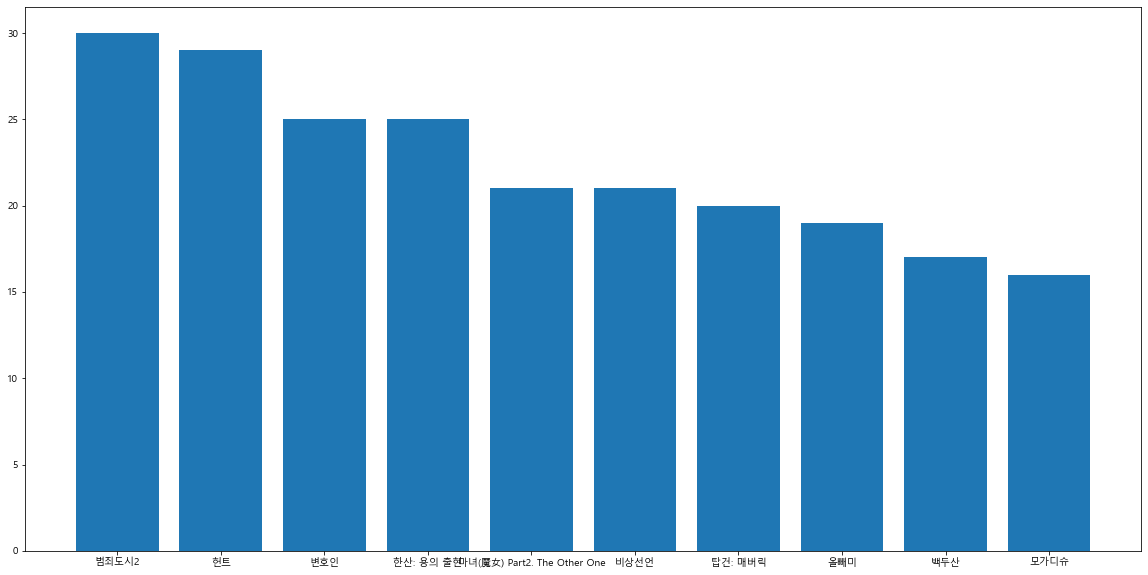

In [58]:
x, y = zip(*stitles[:10])

plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20, 10))

plt.bar(x, y)
plt.show()